# Online Payment Fraud Detection Decision Tree & Random Forest with k-fold cross-validation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

In [4]:
# Load first 100k rows to avoid memory overload
df = pd.read_csv("onlinefraud.csv", nrows=100000)
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (100000, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [6]:
# Drop irrelevant columns
df = df.drop(columns=['nameOrig', 'nameDest'], errors='ignore')

# Drop rows with missing target
df = df.dropna(subset=['isFraud'])

# Encode categorical columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Separate features and target
X = df.drop(columns=['isFraud'])
y = df['isFraud'].values

# Convert all to numeric safely
X = X.apply(pd.to_numeric, errors='coerce')

# Fill any NaNs with column mean
X = X.fillna(X.mean())

# Force float32 type (avoids weird object types)
X = X.astype(np.float32).values

# Normalize features
X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-10)

print("✅ Preprocessing complete. Shape:", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

✅ Preprocessing complete. Shape: (100000, 11)
Training samples: 80000, Testing samples: 20000


In [7]:
tree = DecisionTreeClassifier(max_depth=6, random_state=42)
rf = RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42, n_jobs=-1)

tree.fit(X_train, y_train)
rf.fit(X_train, y_train)

,n_estimators,50
,criterion,'gini'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

def evaluate_model(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    auc = roc_auc_score(y_true, y_prob)
    return cm, precision, recall, f1, auc

cm_rf, prec_rf, rec_rf, f1_rf, auc_rf = evaluate_model(y_test, y_pred_rf, y_prob_rf)

print("\nRandom Forest Results:")
print(f"Precision: {prec_rf:.3f}")
print(f"Recall:    {rec_rf:.3f}")
print(f"F1-score:  {f1_rf:.3f}")
print(f"AUC:       {auc_rf:.3f}")


Random Forest Results:
Precision: 1.000
Recall:    0.391
F1-score:  0.562
AUC:       0.997


In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_cv = RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42, n_jobs=-1)
cv_scores = cross_val_score(rf_cv, X, y, cv=kf, scoring='f1')

print("\nCross-Validation F1 Scores:", np.round(cv_scores, 3))
print("Mean CV F1:", np.mean(cv_scores).round(3))


Cross-Validation F1 Scores: [0.533 0.483 0.421 0.444 0.5  ]
Mean CV F1: 0.476


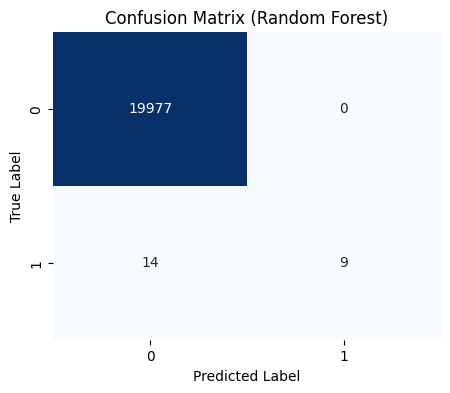

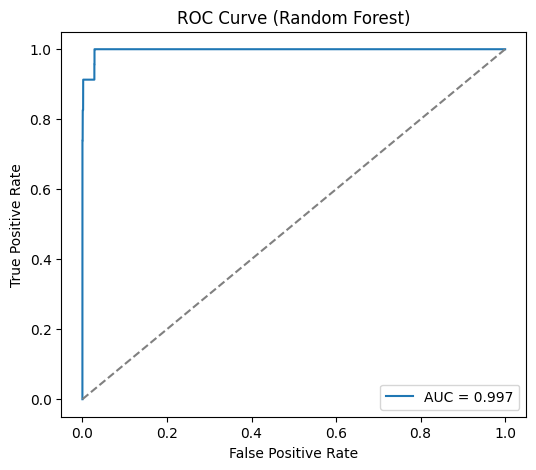

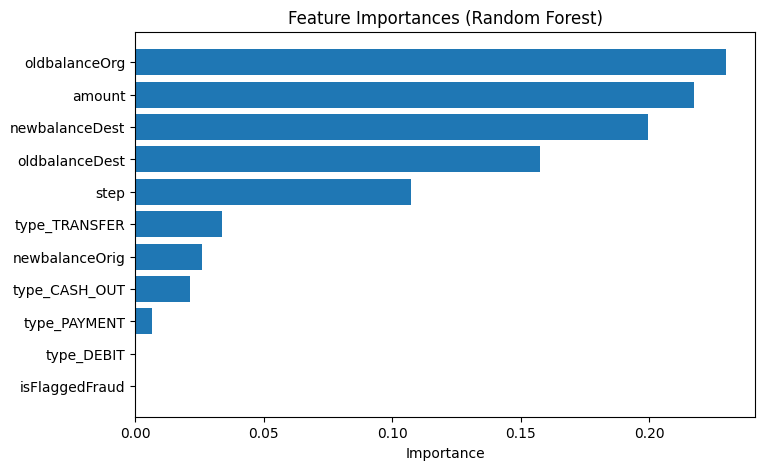

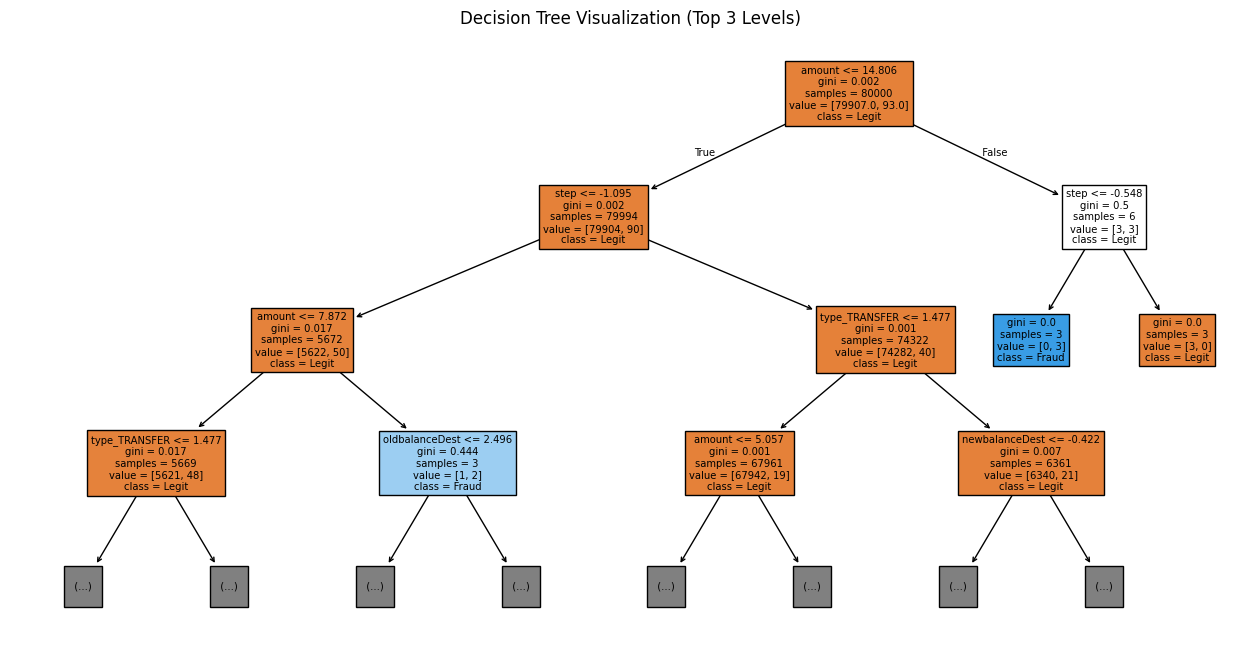

In [10]:
# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_rf:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend()
plt.show()

# Feature Importance
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)
plt.figure(figsize=(8,5))
plt.barh(np.array(df.drop(columns=["isFraud"]).columns)[sorted_idx], importances[sorted_idx])
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

# Decision Tree Visualization (limited depth)
plt.figure(figsize=(16,8))
plot_tree(tree, filled=True,
          feature_names=df.drop(columns=["isFraud"]).columns,
          class_names=["Legit", "Fraud"],
          max_depth=3)
plt.title("Decision Tree Visualization (Top 3 Levels)")
plt.show()


Best Parameters based on F1-score:
max_depth       10.000000
n_estimators    10.000000
F1               0.647059
AUC              0.997185
Name: 15, dtype: float64


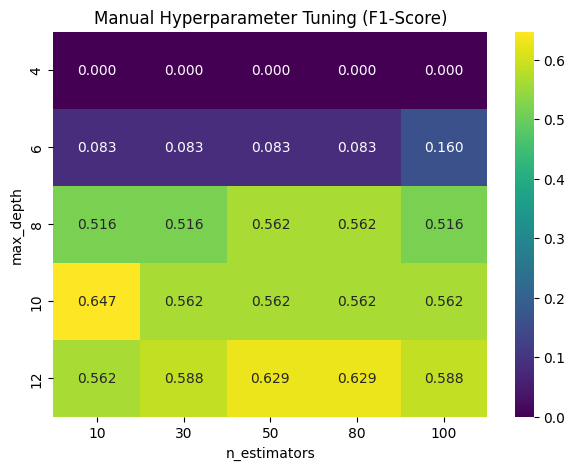

In [12]:
# Hyperparameter Tuning
depths = [4, 6, 8, 10, 12]
n_estimators_list = [10, 30, 50, 80, 100]
results = []

for d in depths:
    for n in n_estimators_list:
        rf_tmp = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42, n_jobs=-1)
        rf_tmp.fit(X_train, y_train)
        y_pred_tmp = rf_tmp.predict(X_test)
        y_prob_tmp = rf_tmp.predict_proba(X_test)[:,1]
        _, _, _, f1, auc = evaluate_model(y_test, y_pred_tmp, y_prob_tmp)
        results.append((d, n, f1, auc))

results_df = pd.DataFrame(results, columns=["max_depth", "n_estimators", "F1", "AUC"])
best = results_df.loc[results_df['F1'].idxmax()]
print("\nBest Parameters based on F1-score:")
print(best)

# Visualization of tuning results
pivot = results_df.pivot(index="max_depth", columns="n_estimators", values="F1")
plt.figure(figsize=(7,5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Manual Hyperparameter Tuning (F1-Score)")
plt.show()

In [14]:
print("\nCONCLUSION:")
print(f"Best Random Forest F1-score: {best.F1:.3f}, AUC: {best.AUC:.3f}")
print(f"Optimal Parameters → Depth: {best.max_depth}, Trees: {best.n_estimators}")
print(f"Most Important Feature → {df.drop(columns=['isFraud']).columns[np.argmax(importances)]}")
print("\nHigh Recall is critical for fraud detection (better to catch more frauds, even if precision drops slightly).")


CONCLUSION:
Best Random Forest F1-score: 0.647, AUC: 0.997
Optimal Parameters → Depth: 10.0, Trees: 10.0
Most Important Feature → oldbalanceOrg

High Recall is critical for fraud detection (better to catch more frauds, even if precision drops slightly).


The model is overfit because of the limitations of my laptop, here we have only taken 100,000 rows out of nearly 6 million, and so the model isn't giving result as expected.